In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [3]:
ratings_raw = pd.read_csv('goodreads_interactions.csv')

In [4]:
ratings_raw.head()

,user_id,book_id,is_read,rating,is_reviewed
0,0,948,1,5,0
1,0,947,1,5,1
2,0,946,1,5,0
3,0,945,1,5,0
4,0,944,1,5,0


In [5]:
df_stats = pd.DataFrame([ratings_raw.shape[0],
                         ratings_raw['is_read'].sum(),
                         (ratings_raw['rating']>0).sum(),
                         ratings_raw['is_reviewed'].sum()], dtype = float, 
                        columns = ['count'],
                        index = ['# shelve', '# read', '# rate', '# review'])
display(df_stats)

,count
# shelve,228648342.0
# read,112131203.0
# rate,104551549.0
# review,16219149.0


- Shelve - Total number of records in the dataset
- Read - Number of records where user read the books
- Rated - Number of records where users provided rating scores for the books
- Reviewed - Number of records where the book review texts are not empty

In [6]:
ratings_raw.isnull().sum()

user_id        0
book_id        0
is_read        0
rating         0
is_reviewed    0
dtype: int64

In [7]:
import seaborn as sns

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


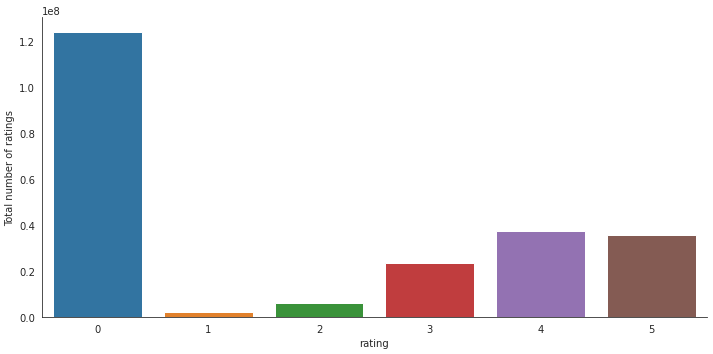

In [8]:
with sns.axes_style('white'):
    g = sns.factorplot("rating", data=ratings_raw, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [9]:
ratings_whole = ratings_raw[ratings_raw['rating']!=0]

In [10]:
ratings_whole.drop(["is_read", "is_reviewed"], inplace=True, axis=1)

C:\Users\GreyMan97\AppData\Local\Temp\ipykernel_27360\701588699.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_whole.drop(["is_read", "is_reviewed"], inplace=True, axis=1)


In [11]:
ratings_whole.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104551549 entries, 0 to 228648341
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   user_id  int64
 1   book_id  int64
 2   rating   int64
dtypes: int64(3)
memory usage: 3.1 GB


In [12]:
ratings_whole.shape

(104551549, 3)

In [13]:
ratings_1000th = ratings_whole.iloc[[x for x in range(ratings_whole.shape[0]) if x%999==0]]

In [14]:
train, test = train_test_split(ratings_1000th, test_size=0.2, random_state=42)

In [15]:
test.shape

(20932, 3)

In [16]:
n_users = max(ratings_1000th.user_id.unique())
n_users

876135

In [17]:
n_books = max(ratings_1000th.book_id.unique())
n_books

2359861

## Dot product model

In [18]:
book_input = Input(shape=[1], name="Book-Input")
book_embedding = Embedding(n_books+1, 5, name="Book-Embedding")(book_input)
book_vec = Flatten(name="Flatten-Books")(book_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# performing dot product and creating model
prod = Dot(name="Dot-Product", axes=1)([book_vec, user_vec])
model = Model([user_input, book_input], prod)
model.compile('adam', 'mean_squared_error')

In [19]:
history = model.fit([train.user_id, train.book_id], train.rating, epochs=9, verbose=1)
model.save('regression_model.h5')

Epoch 1/9
2617/2617 [==============================] - 296s 113ms/step - loss: 16.5183
Epoch 2/9
2617/2617 [==============================] - 303s 116ms/step - loss: 16.4440
Epoch 3/9
2617/2617 [==============================] - 310s 119ms/step - loss: 16.1834
Epoch 4/9
2617/2617 [==============================] - 321s 123ms/step - loss: 15.6691
Epoch 5/9
2617/2617 [==============================] - 299s 114ms/step - loss: 14.9285
Epoch 6/9
2617/2617 [==============================] - 319s 122ms/step - loss: 14.0176
Epoch 7/9
2617/2617 [==============================] - 329s 126ms/step - loss: 13.0018
Epoch 8/9
2617/2617 [==============================] - 311s 119ms/step - loss: 11.9509
Epoch 9/9
2617/2617 [==============================] - 293s 112ms/step - loss: 10.9222


Text(0, 0.5, 'Training Error')

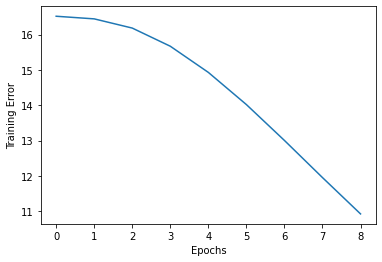

In [20]:
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

In [21]:
model.evaluate([test.user_id, test.book_id], test.rating)

655/655 [==============================] - 0s 484us/step - loss: 16.4390


16.438961029052734

In [22]:
predictions = model.predict([test.user_id.head(10), test.book_id.head(10)])

[print(predictions[i], test.rating.iloc[i]) for i in range(0,10)]

[-0.00292608] 2
[-0.0012863] 5
[-0.00142956] 4
[0.02587566] 2
[0.00163685] 3
[-0.00188358] 2
[0.00117171] 2
[0.07591727] 5
[0.00126497] 3
[-0.00068531] 5


[None, None, None, None, None, None, None, None, None, None]

## Neural Network 

In [23]:
from tensorflow.keras.layers import Concatenate

# creating book embedding path
book_input = Input(shape=[1], name="Book-Input")
book_embedding = Embedding(n_books+1, 5, name="Book-Embedding")(book_input)
book_vec = Flatten(name="Flatten-Books")(book_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenate features
conc = Concatenate()([book_vec, user_vec])

# add fully-connected-layers
fc1 = Dense(128, activation='relu')(conc)
fc2 = Dense(32, activation='relu')(fc1)
out = Dense(1)(fc2)

# Create model and compile it
model2 = Model([user_input, book_input], out)
model2.compile('adam', 'mean_squared_error')

In [24]:
history2 = model2.fit([train.user_id, train.book_id], train.rating, epochs=9, verbose=1)
model2.save('regression_model2.h5')

Epoch 1/9
2617/2617 [==============================] - 337s 129ms/step - loss: 1.1825
Epoch 2/9
2617/2617 [==============================] - 312s 119ms/step - loss: 0.7228
Epoch 3/9
2617/2617 [==============================] - 296s 113ms/step - loss: 0.3259
Epoch 4/9
2617/2617 [==============================] - 307s 117ms/step - loss: 0.1393
Epoch 5/9
2617/2617 [==============================] - 300s 115ms/step - loss: 0.0813
Epoch 6/9
2617/2617 [==============================] - 295s 113ms/step - loss: 0.0573
Epoch 7/9
2617/2617 [==============================] - 297s 114ms/step - loss: 0.0422
Epoch 8/9
2617/2617 [==============================] - 320s 122ms/step - loss: 0.0359
Epoch 9/9
2617/2617 [==============================] - 336s 128ms/step - loss: 0.0315


Text(0, 0.5, 'Training Error')

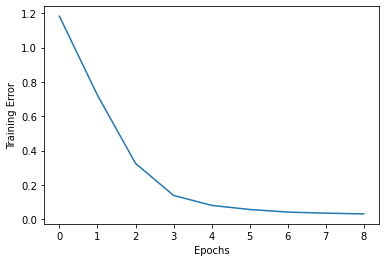

In [25]:
plt.plot(history2.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

In [26]:
model2.evaluate([test.user_id, test.book_id], test.rating)

655/655 [==============================] - 0s 535us/step - loss: 1.0869


1.086936354637146

In [27]:
from tensorflow.keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(float(y_pred) - float(y_true)))) 

model3 = Model([user_input, book_input], out)
model3.compile(optimizer = "rmsprop", loss = root_mean_squared_error, metrics =["accuracy"])

In [28]:
history3 = model3.fit([train.user_id, train.book_id], train.rating, epochs=5, verbose=1)
model3.save('regression_model3.h5')

Epoch 1/5
2617/2617 [==============================] - 107s 41ms/step - loss: 0.1708 - accuracy: 0.0198
Epoch 2/5
2617/2617 [==============================] - 112s 43ms/step - loss: 0.1391 - accuracy: 0.0198
Epoch 3/5
2617/2617 [==============================] - 97s 37ms/step - loss: 0.1166 - accuracy: 0.0198
Epoch 4/5
2617/2617 [==============================] - 100s 38ms/step - loss: 0.0996 - accuracy: 0.0198
Epoch 5/5
2617/2617 [==============================] - 127s 48ms/step - loss: 0.0860 - accuracy: 0.0198


Text(0, 0.5, 'Training Error')

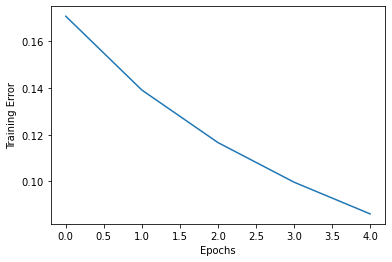

In [29]:
plt.plot(history3.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

In [30]:
model3.evaluate([test.user_id, test.book_id], test.rating)

655/655 [==============================] - 1s 2ms/step - loss: 1.0337 - accuracy: 0.0202


[1.0337337255477905, 0.020208293572068214]